**Vertical Strategy: Use text column to predict tex_paragraph column**

**Outline**

1. ✅ filter out stopwords in text column
    - word tokenize text column
2. ✅  use token match in big string to define candidate paragraphs
    - merge overlapping paragraphs
3. ✅ Score/rank paragraphs
    - some terms will be more relevant/weighted than others
    - also score them by requency
4. ✅ Check similarity between predicted paragraphs and actual paragraphs

# Vertical Pipeline: turn vertical strategy into something easily iterable
- like a function callable on an html that returns a nominated paragraph

In [130]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import datetime

## Generate parameters from curated training data

### read in the vertical training subset data frame

In [17]:
### read in the vertical training subset
vert_training_subset_df = pd.read_csv('data/vertical_training_subset.csv', index_col=[0])
vert_training_subset_df.head(2)

In [ ]:
### these are the only dkfns that I'm currently working with
print(set(vert_training_subset_df.data_key_friendly_name))

### generate key_tokens from text colum

In [15]:
### compile a string from the text column

text_list = [t.lower() for t in vert_training_subset_df.text]
#print('This is what the text_list looks like: ')
#print("----------------------------")
#print(text_list[0:3])
#print("----------------------------")
text_string = ''
for t in text_list:
    text_string = text_string + t + ' '
#print("")
#print("And now this is what the flattened text_string looks like: ")
#print("----------------------------")
#print(text_string[0:250])
#print("----------------------------")

In [23]:
### tokenize the text string

text_tokens = [w for w in word_tokenize(text_string) if w.isalpha()]
no_stops = [t for t in text_tokens if t not in stopwords.words('english')]
#print(no_stops[0:10])

### limit ourselves to the 30 most common tokens
    # although this can be modulated if necessary
key_tokens = pd.DataFrame(Counter(no_stops).most_common(30))
key_tokens.columns = ['key_tok', 'kt_count']

can probably improve the above list of key_tokens by using less than 30 terms.... maybe

#### 🤔 I could enhance my key_tokens by doing tf-idf
- between the text column and the the html text - the text column
    - which terms are prominent in text column that are not prominent in the rest of the html
    - which terms are prominent in the noisy signal that are not prominent in the noise?
- I could also enhance it by removing noisy words like 'total'

### define paragraph margins
as the standard deviation of paragraph lengths

In [22]:
par_lengths = [len(par) for par in vert_training_subset_df.paragraph_text]
margin = int(np.std(par_lengths))

## This will be the beginning of the loop
1. read in a filing
2. call a function that
    - defines candidate paragraphs
    - ranks or scores candidate paragraphs to select top nominee(s)
    - validates if predicted nominee is a good match to actual paragraph in the training csv.

### Stage filings to be read in iterably

In [20]:
# initialize a list of paths
training_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_training_filings/'):
    training_filings_list += glob.glob(os.path.join(root, '*.html'))
#print(training_filings_list[0:3])

# need to isolate only those filings which are in my vertical training df

In [39]:
len(set(vert_training_subset_df.accession_number))

278

In [42]:
len(set(['data/nc_training_filings/' + an + '.html' for an in vert_training_subset_df.accession_number]))

278

In [47]:
vert_training_subset_filings_list = list(set(['data/nc_training_filings/' + an + '.html' for an in vert_training_subset_df.accession_number]))
vert_training_subset_filings_list
assert len(vert_training_subset_filings_list) == len(set(vert_training_subset_df.accession_number))

In [106]:
len(vert_training_subset_filings_list)

278

In [132]:
datetime.datetime.now()

datetime.datetime(2018, 6, 2, 23, 6, 36, 168644)

# for now, lets practice on only filings in vertical_training_subset

In [133]:
# initialize some score keeping lists
total_inclusion = []
inclusion_rates = []

#for filing in training_filings_list:
#for filing in vert_training_subset_filings_list[0:100]:
for filing in vert_training_subset_filings_list:
    ti = datetime.datetime.now()
    print('processing next filing at ', ti)
    
    
### this could be all be packed into a function if nec.
###
    # read in the filing's html
    with open(filing) as file:
        file_html = file.read()
    
    # parse the html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ################################################################
    #define candidate paragraphs by clustering of overlapping token-hit-margins
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraphs and a hit tracker
    candidate_paragraphs = []
    hit = 0
    #
    # work through the hits until I exhaust the list
    while hit < len(flater_list_of_tokhits) - 1:
    #    
        # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
    #     
        # loop from the hit + 1 (cause we used the former hit to initialize the bounds)
        for i in range(hit + 1, len(flater_list_of_tokhits)):
            # if the next token's start is within the current paragraph's bounds and it isnt the last hit
            if (leftbound < flater_list_of_tokhits[i][1] < rightbound) and (i != len(flater_list_of_tokhits) - 1):
                # expand the right bound with respect to next token's end
                rightbound = flater_list_of_tokhits[i][2] + margin
    #             
            # if next token is outside the bounds of current paragraph or we are at the penultimate hit
            else:
                # if right bound is out of htmls range, then adjust it to the end of the html
                if rightbound > len(string_filing):
                    rightbound = len(string_filing)
                # define current paragraph
                par = string_filing[leftbound:rightbound] ########### (if the code needs to be made more efficient I could store the paragraph start and end indices instead of storing the strings)
                # store the paragraph in a list of candidates
                candidate_paragraphs.append(par)
                # note which hit we need to start on for the next iteration of the while loop
                hit = i
                # now that we've found the outer bounds of the current paragraph we can interrupt the for loop
                break #this won't interrupt the while loop 😊 
    #
    # this is just a repetition of the above routine to handle the last hit. There is probably a better way to handle this but we can enhance that later
    if hit == len(flater_list_of_tokhits)-1:
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
        if rightbound > len(string_filing):
            rightbound = len(string_filing)
        par = string_filing[leftbound:rightbound]
        candidate_paragraphs.append(par)
    #
    # --------------- store the candidate paragraphs in a df ------------------
    candidate_df = pd.DataFrame(candidate_paragraphs)
    candidate_df.columns = ['cand_par']
    candidate_df['len'] = [len(par) for par in candidate_df.cand_par]
    # --------------- rank the candidate paragraphs by basic length (longer paragraphs correspond to denser clusters)
    candidate_df.sort_values(by = 'len', ascending = False, inplace = True)
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- filter candidates downto those with 'repurchase' in them
    candidate_df = candidate_df[['repurchase' in par for par in candidate_df.cand_par]]
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- nominee(s) will be the top 1 - 3 in the filterd df
    nominated = candidate_df.cand_par[0]
    # clean up the nominee for validation
    nom_validatable = re.sub(r'\n+', ' ', nominated) # remove new lines
    nom_validatable = re.sub(r'\s+', ' ', nom_validatable) # trim all repeated whitespace down to one
    # --------------- isolate csv's actual paragraph for valiation
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    # use it to filter down to the csv rows with that an
    actual_paragraph = vert_training_subset_df[vert_training_subset_df.accession_number == an].head(1).paragraph_text
    # extract the string from the resulting pandas series
    actual_paragraph = actual_paragraph.values[0]
    # cast the string to lower case
    actual_paragraph = actual_paragraph.lower()
    # eliminate excess spaces
    actual_paragraph = re.sub(r'\s+', ' ', actual_paragraph)
    
    # moment of truth
    #---------------------------------------------------------
    #print('Actual_paragraph in nom_validatable: ')
    #print('----------', actual_paragraph in nom_validatable)
    
    counter = 0
    for wt in word_tokenize(actual_paragraph):
        if wt in word_tokenize(nom_validatable):
            counter += 1
    #print('word tokens actual_paragraph also in word_tokenise(nom_validatable)')
    #print('---------- counter = ', counter)
    x = round(100*counter/len(word_tokenize(actual_paragraph)),2)
    #print('that is a ', x, '% inclusion')
    #print("-------------------------------------------------")
    #print("")
    
    # keeping score
    total_inclusion.append(actual_paragraph in nom_validatable)
    inclusion_rates.append(x)
    tf = datetime.datetime.now()
    print('finished processing ', len(total_inclusion), 'th filing at ', tf)
    print('process took', tf - ti)
    print("--------------------------")

processing next filing at  2018-06-02 23:10:23.395083


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


finished processing  1 th filing at  2018-06-02 23:10:26.330288
process took 0:00:02.935205
--------------------------
processing next filing at  2018-06-02 23:10:26.330528
finished processing  2 th filing at  2018-06-02 23:10:28.137957
process took 0:00:01.807429
--------------------------
processing next filing at  2018-06-02 23:10:28.138135
finished processing  3 th filing at  2018-06-02 23:10:29.842976
process took 0:00:01.704841
--------------------------
processing next filing at  2018-06-02 23:10:29.843353
finished processing  4 th filing at  2018-06-02 23:10:31.063258
process took 0:00:01.219905
--------------------------
processing next filing at  2018-06-02 23:10:31.063436
finished processing  5 th filing at  2018-06-02 23:10:32.587713
process took 0:00:01.524277
--------------------------
processing next filing at  2018-06-02 23:10:32.587899
finished processing  6 th filing at  2018-06-02 23:10:35.070429
process took 0:00:02.482530
--------------------------
processing next 

finished processing  49 th filing at  2018-06-02 23:12:01.321124
process took 0:00:03.061772
--------------------------
processing next filing at  2018-06-02 23:12:01.321320
finished processing  50 th filing at  2018-06-02 23:12:02.803189
process took 0:00:01.481869
--------------------------
processing next filing at  2018-06-02 23:12:02.803470
finished processing  51 th filing at  2018-06-02 23:12:03.974285
process took 0:00:01.170815
--------------------------
processing next filing at  2018-06-02 23:12:03.974459
finished processing  52 th filing at  2018-06-02 23:12:05.422975
process took 0:00:01.448516
--------------------------
processing next filing at  2018-06-02 23:12:05.423194
finished processing  53 th filing at  2018-06-02 23:12:08.149890
process took 0:00:02.726696
--------------------------
processing next filing at  2018-06-02 23:12:08.150130
finished processing  54 th filing at  2018-06-02 23:12:10.342566
process took 0:00:02.192436
--------------------------
processing

finished processing  97 th filing at  2018-06-02 23:13:28.866988
process took 0:00:02.050654
--------------------------
processing next filing at  2018-06-02 23:13:28.867194
finished processing  98 th filing at  2018-06-02 23:13:31.182695
process took 0:00:02.315501
--------------------------
processing next filing at  2018-06-02 23:13:31.182917
finished processing  99 th filing at  2018-06-02 23:13:32.479375
process took 0:00:01.296458
--------------------------
processing next filing at  2018-06-02 23:13:32.479843
finished processing  100 th filing at  2018-06-02 23:13:34.563601
process took 0:00:02.083758
--------------------------
processing next filing at  2018-06-02 23:13:34.563865
finished processing  101 th filing at  2018-06-02 23:13:36.745923
process took 0:00:02.182058
--------------------------
processing next filing at  2018-06-02 23:13:36.746143
finished processing  102 th filing at  2018-06-02 23:13:37.810887
process took 0:00:01.064744
--------------------------
process

finished processing  144 th filing at  2018-06-02 23:15:02.276230
process took 0:00:02.865723
--------------------------
processing next filing at  2018-06-02 23:15:02.276529
finished processing  145 th filing at  2018-06-02 23:15:02.927335
process took 0:00:00.650806
--------------------------
processing next filing at  2018-06-02 23:15:02.927520
finished processing  146 th filing at  2018-06-02 23:15:03.779762
process took 0:00:00.852242
--------------------------
processing next filing at  2018-06-02 23:15:03.779968
finished processing  147 th filing at  2018-06-02 23:15:04.790404
process took 0:00:01.010436
--------------------------
processing next filing at  2018-06-02 23:15:04.790939
finished processing  148 th filing at  2018-06-02 23:15:06.401338
process took 0:00:01.610399
--------------------------
processing next filing at  2018-06-02 23:15:06.401556
finished processing  149 th filing at  2018-06-02 23:15:08.263554
process took 0:00:01.861998
--------------------------
proc

finished processing  191 th filing at  2018-06-02 23:16:30.890304
process took 0:00:02.832765
--------------------------
processing next filing at  2018-06-02 23:16:30.890532
finished processing  192 th filing at  2018-06-02 23:16:32.518767
process took 0:00:01.628235
--------------------------
processing next filing at  2018-06-02 23:16:32.518957
finished processing  193 th filing at  2018-06-02 23:16:35.367416
process took 0:00:02.848459
--------------------------
processing next filing at  2018-06-02 23:16:35.367667
finished processing  194 th filing at  2018-06-02 23:16:38.048166
process took 0:00:02.680499
--------------------------
processing next filing at  2018-06-02 23:16:38.048603
finished processing  195 th filing at  2018-06-02 23:16:41.172758
process took 0:00:03.124155
--------------------------
processing next filing at  2018-06-02 23:16:41.172963
finished processing  196 th filing at  2018-06-02 23:16:43.613351
process took 0:00:02.440388
--------------------------
proc

finished processing  238 th filing at  2018-06-02 23:18:03.695176
process took 0:00:01.389316
--------------------------
processing next filing at  2018-06-02 23:18:03.695407
finished processing  239 th filing at  2018-06-02 23:18:04.994076
process took 0:00:01.298669
--------------------------
processing next filing at  2018-06-02 23:18:04.994318
finished processing  240 th filing at  2018-06-02 23:18:06.447522
process took 0:00:01.453204
--------------------------
processing next filing at  2018-06-02 23:18:06.447791
finished processing  241 th filing at  2018-06-02 23:18:08.053626
process took 0:00:01.605835
--------------------------
processing next filing at  2018-06-02 23:18:08.054459
finished processing  242 th filing at  2018-06-02 23:18:09.116997
process took 0:00:01.062538
--------------------------
processing next filing at  2018-06-02 23:18:09.117236
finished processing  243 th filing at  2018-06-02 23:18:12.155672
process took 0:00:03.038436
--------------------------
proc

In [134]:
print(total_inclusion)

[False, False, True, False, False, False, False, False, False, True, False, False, True, True, False, True, True, False, True, False, True, False, False, False, True, True, False, False, False, False, True, True, False, False, True, True, False, False, True, False, False, True, False, False, True, True, True, False, False, True, True, False, True, False, False, False, False, True, True, True, False, True, False, True, False, False, True, False, False, True, False, False, False, True, False, True, False, True, True, True, True, False, False, False, False, False, True, False, False, False, True, False, False, False, True, True, True, True, False, True, False, True, True, False, False, True, False, False, False, True, False, False, False, False, False, False, True, False, True, False, False, False, False, True, True, False, True, True, False, False, True, True, True, False, True, False, False, False, True, True, False, False, False, False, True, False, True, False, True, False, False, Fal

In [135]:
# total filings processed
len(total_inclusion)

278

In [136]:
# number of actual paragraphs 100% included
np.array(total_inclusion).sum()

108

In [137]:
# total inclusion rate
print(round(100*np.array(total_inclusion).sum()/len(total_inclusion), 2), '% total inclusion')

38.85 % total inclusion


In [138]:
# rates of inclusion of actual paragraphs in predicted paragraphs
print(inclusion_rates)

[78.79, 53.85, 100.0, 53.57, 45.0, 45.24, 77.27, 100.0, 71.74, 100.0, 99.05, 57.14, 100.0, 100.0, 47.56, 100.0, 100.0, 76.67, 100.0, 42.7, 100.0, 50.98, 57.55, 2.04, 100.0, 100.0, 50.0, 46.67, 100.0, 94.19, 100.0, 100.0, 76.14, 85.82, 100.0, 100.0, 100.0, 20.56, 100.0, 41.27, 46.0, 100.0, 59.68, 50.98, 100.0, 100.0, 100.0, 98.48, 67.74, 100.0, 100.0, 89.94, 100.0, 47.55, 67.33, 55.93, 68.85, 100.0, 100.0, 100.0, 100.0, 100.0, 44.23, 99.04, 94.44, 56.52, 100.0, 100.0, 62.76, 100.0, 93.33, 73.61, 64.81, 100.0, 67.82, 100.0, 99.2, 100.0, 100.0, 100.0, 100.0, 65.52, 100.0, 57.14, 53.45, 45.45, 100.0, 81.08, 51.69, 76.56, 100.0, 94.38, 59.55, 58.82, 100.0, 100.0, 100.0, 100.0, 91.23, 100.0, 97.56, 100.0, 100.0, 94.94, 59.62, 100.0, 98.91, 68.29, 46.0, 100.0, 93.88, 89.89, 64.43, 41.45, 44.44, 60.87, 100.0, 68.16, 100.0, 75.41, 97.14, 65.49, 100.0, 99.12, 100.0, 45.71, 100.0, 100.0, 69.23, 100.0, 100.0, 100.0, 100.0, 80.85, 100.0, 83.51, 84.55, 71.05, 100.0, 100.0, 53.33, 54.55, 80.52, 76.39

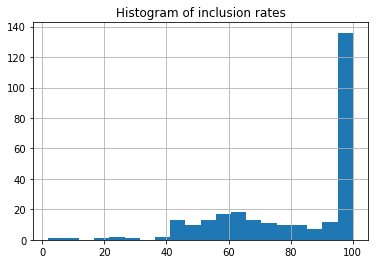

In [145]:
plt.hist(inclusion_rates, bins=20)
plt.title('Histogram of inclusion rates')
plt.grid()
plt.show()

In [140]:
# mean inclusion rate
np.mean(np.array(inclusion_rates))

81.56730215827338

In [141]:
# median inclusion rate
np.median(np.array(inclusion_rates))

94.285

## For now, ranking paragraphs by something as unrefined as brute length is working well enough
### filtering the candidate paragraphs to those containing 'repurchase' worked well too. 

## 🤔 💡 
#### can enhance by counting how many key_token hits each paragraph has
#### can enhance by assigning weighted values to certain key_tokens